## DEAP: Genetic Algorithm and Genetic Programming Tutorial

In [564]:
%pip install deap 

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np

In [3]:
from deap import base, creator, tools, algorithms

### Simple Genetic Algorithm

<b>Overall flow of a *Genetic Algorithm*:</b>

    1) Population Initialisation 
    2) Fitness computation
    3) Evolution (crossover and mutation) 
    4) Next population selection (include fitness computation)
    5) Termination check 
        5-1) yes: Done. Return the best solution found so far 
        5-2) no: go to 3)  

<b>Four main steps of DEAP</b>: 

    1) Type Definition, 
    2) Initialisation, 
    3) Operator defintion & register, 
    4) Algorithm 

#### Examples: one-max problem 

Evolve until obtaining an individual with all 1s. 

<b>1) Type defintion </b>

In [494]:
# define the individual type for one-max problem 
creator.create("FitnessMax", base.Fitness, weights = (1.0,))
creator.create("OneMaxIndividual", list, fitness = creator.FitnessMax)

/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'OneMaxIndividual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [88]:
#creator.OneMaxIndividual

<b>2) Initialisation </b>

In [495]:
ind_size = 100
pop_size = 50

toolbox = base.Toolbox() # a contaner for tools of all sorts including initialiser 
# define intialisers and register them into toolbox
toolbox.register("attribute", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.OneMaxIndividual, toolbox.attribute, n = ind_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n = pop_size)


<b>3) Operator defintion & register </b>

In [496]:
# all operators that will be used during GA including the evolution operators 
def count_one(ind): # ~= fitness computation 
    return (np.sum(ind),)

toolbox.register("evaluate", count_one) # can pass the data here
toolbox.register("mate", tools.cxOnePoint) 
toolbox.register("mutate", tools.mutFlipBit, indpb = 1/ind_size) 
toolbox.register("select", tools.selTournament, tournsize = 3, fit_attr = "fitness") # fit_tarr = the name of the attribute to use, 

In [ ]:
tools.selRoulette()

In [497]:
# checking 
toolbox.evaluate

functools.partial(<function count_one at 0x139176f70>)

<b>4) Algorithm </b>

In [498]:
n_gen = 50
cxRate = 1.0
mutRate = 0.2

In [509]:
## 1) population initialisation 
pop = toolbox.population() # n = new_pop_size

In [500]:
pop[0].fitness.values, pop[0].fitness.valid # none assigned

((), False)

In [501]:
## 2) fitness evaluation 
fitness_per_ind = toolbox.map(toolbox.evaluate, pop)
for ind,fit_v in zip(pop, fitness_per_ind):
    ind.fitness.values = fit_v

In [503]:
## 2-2) select the best individual & store
best = tools.HallOfFame(1) # similar = ... # define for duplicate check 
print (best)
best.update(pop)
print (best[0])

[]
[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]


In [504]:
## logging ##
stats = tools.Statistics(lambda ind:ind.fitness.values[0])
stats.register("max", np.max, axis = 0)
stats.register("min", np.min, axis = 0)
stats.register("average", np.mean, axis = 0)

In [505]:
stat_results = stats.compile(pop)
print (stat_results)

{'max': 60.0, 'min': 40.0, 'average': 49.46}


In [506]:
logbook = tools.Logbook()
logbook.record(
    gen = 0, 
    max = stat_results['max'],
    min = stat_results['min'],
    mean = stat_results['average'],
)
print (logbook)

gen	max	mean 	min
0  	60 	49.46	40 


In [539]:
## 3) evolution & 4) next population selection 
from tqdm import tqdm 
allow_dup = True
for gen_idx in tqdm(range(1, n_gen + 1)):
    # 3) evoluation 
    offsprings = []
    pop_copied = [toolbox.clone(ind) for ind in pop]
    while len(offsprings) < pop_size:
        offspring = toolbox.select(pop_copied, 2)
        ## crossover
        if random.random() < cxRate:
            offspring[0], offspring[1] = toolbox.mate(offspring[0], offspring[1])
            del offspring[0].fitness.values, offspring[1].fitness.values
        # muate 
        if random.random() < mutRate:
            offspring[0], = toolbox.mutate(offspring[0])
            del offspring[0].fitness.values
        if random.random() < mutRate:
            offspring[1], = toolbox.mutate(offspring[1])
            del offspring[1].fitness.values
        ind1, ind2 = offspring
        #ind1, ind2 = algorithms.varAnd(offspring, toolbox, cxRate, mutRate) 
        
        # check duplicate & include 
        if len(offsprings) == 0 or allow_dup:
            offsprings.extend([ind1, ind2])
        else:
            incl = True 
            for _ind in offsprings:
                if str(_ind).__eq__(str(ind1)): incl = False; break 
            if incl: 
                offsprings.append(ind1)
            incl = True 
            for _ind in offsprings:
                if str(_ind).__eq__(str(ind2)): incl = False; break 
            if incl: 
                offsprings.append(ind2) 
    
    # 4) next population selection 
    ## 4-1) fitness computation for new offsrpings 
    new_inds = [ind for ind in offsprings if ind.fitness.valid]
    fitness_per_ind = toolbox.map(toolbox.evaluate, new_inds)
    for ind, fit_v in zip(new_inds, fitness_per_ind):
        ind.fitness.values = fit_v 
    ## 4-2) the next population selection 
    pop[:] = tools.selBest(pop + offsprings, pop_size)
    # update best
    best.update(pop)

    # logbox 
    stat_results = stats.compile(pop)
    max_v, min_v, avg_v = stat_results['max'], stat_results['min'], stat_results['average']
    logbook.record(gen = gen_idx, max = max_v, min = min_v, mean = avg_v)
    #print (logbook)
    # some termination condition: the number of unchanged cases 
    if toolbox.evaluate(best[0])[0] == ind_size:
        print (f"At Gen {gen_idx}, the optimal found")
        break 

print (logbook)
print ("\n")
print (best[0])

100%|██████████| 50/50 [00:00<00:00, 144.87it/s]

gen	max	mean 	min
0  	61 	48.98	36 
1  	61 	53.94	51 
2  	62 	57.92	55 
3  	65 	60.74	58 
4  	68 	63.36	61 
5  	70 	66.12	63 
6  	71 	68.62	66 
7  	72 	70.08	69 
8  	72 	71.14	70 
9  	75 	71.98	71 
10 	77 	73.34	72 
11 	78 	75.12	73 
12 	80 	76.86	75 
13 	81 	78.14	77 
14 	81 	79.34	78 
15 	82 	80.24	80 
16 	82 	80.68	80 
17 	83 	81.36	81 
18 	83 	81.8 	81 
19 	83 	82.34	82 
20 	85 	83.32	83 
21 	85 	83.88	83 
22 	85 	84.54	84 
23 	86 	85.02	84 
24 	86 	85.3 	85 
25 	87 	85.78	85 
26 	87 	86.44	86 
27 	88 	87.1 	87 
28 	89 	87.32	87 
29 	89 	87.76	87 
30 	89 	88.2 	88 
31 	89 	88.42	88 
32 	89 	88.9 	88 
33 	90 	89.14	89 
34 	90 	89.3 	89 
35 	90 	89.72	89 
36 	91 	90.04	90 
37 	91 	90.04	90 
38 	92 	90.12	90 
39 	92 	90.32	90 
40 	92 	91   	90 
41 	92 	91.38	91 
42 	93 	92.02	91 
43 	93 	92.14	92 
44 	93 	92.42	92 
45 	94 	93.16	93 
46 	95 	93.46	93 
47 	96 	94.34	93 
48 	97 	95.16	94 
49 	97 	95.9 	95 
50 	97 	96.2 	96 


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

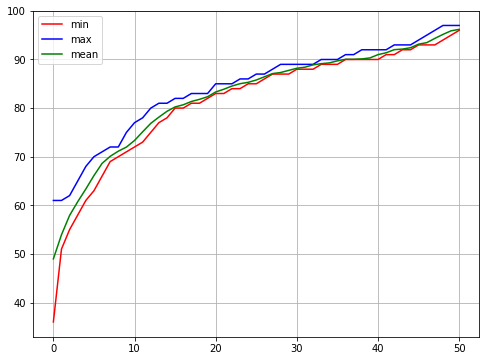

In [540]:
# visulation 
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

gen_vs, min_vs, max_vs, mean_vs = logbook.select("gen", "min", "max", 'mean')
ax.plot(gen_vs, min_vs, c = 'r', label = 'min')
ax.plot(gen_vs, max_vs, c = 'b', label = 'max')
ax.plot(gen_vs, mean_vs, c = 'g', label = 'mean')

ax.grid()
plt.legend()
plt.show()

#### Using pre-implemented evolutionary algorithms

In [541]:
pop = toolbox.population(n = pop_size)
algorithms.eaSimple(pop, toolbox, cxRate, mutRate, ngen=n_gen, stats = stats, verbose= False)
best_found = tools.selBest(pop, 1)
print (best_found, np.sum(best_found))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]] 98


#### Exercises

<b>Traveling Salesman Problem</b>

* Individual: a candidate city visiting order
* Fitness: minmise the total distance when visiting the cities sequentially as indicated in the individual
* crossover:
    - tools.cxOrderd 
* mutation: shuffligng 
    - tools.mutShuffleIndexs, indpb = 1/n_cities 
* parent selection:
    - tools.selTournament, tournsize = 3
* next population selection: select the top pop_size best individuals 
    - tools.selBest 

In [1]:
pop_size = 100
n_cities = 10

In [4]:
# provided
from itertools import combinations
edges = list(combinations(np.arange(n_cities), 2))
dist_btwn_cities = {}
for c1,c2 in edges:
    dist = np.random.rand()
    dist_btwn_cities[(c1,c2)] = dist 
    dist_btwn_cities[(c2,c1)] = dist 

In [542]:
# define types 
creator.create("TSPFitnesMin", base.Fitness, weights = (-1.0,))
creator.create("TSPIndividual", list, fitness = creator.TSPFitnesMin)

# initialisation  
cities = np.arange(n_cities)
tsp_toolbox = base.Toolbox()
tsp_toolbox.register("order", np.random.permutation, n_cities)
tsp_toolbox.register("tsp_individual", tools.initIterate, creator.TSPIndividual, tsp_toolbox.order)
tsp_toolbox.register("tsp_population", tools.initRepeat, list, tsp_toolbox.tsp_individual, n = pop_size) 

# operator 
def evaluate(cand_order, dists): # need to implement 
    total_dist = 0.
    for i in range(1, len(cand_order)):
        total_dist += dists[(cand_order[i-1], cand_order[i])]
    return (total_dist,)

tsp_toolbox.register("evaluate", evaluate, dists = dist_btwn_cities)
tsp_toolbox.register("mate", tools.cxOrdered)
tsp_toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 1/n_cities)
tsp_toolbox.register("select", tools.selTournament, tournsize = 3)

/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'TSPIndividual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [543]:
n_gen = 50
cxRate = 1.0 
mutRate = 0.2 

# algorithm 
# 1) population initialisation 
pop = tsp_toolbox.tsp_population(n = pop_size)
# 2) fitness evaluation 
fitness_per_ind = tsp_toolbox.map(tsp_toolbox.evaluate, pop)
for ind, fit_v in zip(pop, fitness_per_ind):
    ind.fitness.values = fit_v 

# 2-2) select the best individual & store
best = tools.HallOfFame(1)
best.update(pop)

# logging 
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("max", np.max, axis = 0)
stats.register("min", np.min, axis = 0)
stats.register("mean", np.mean, axis = 0)
stat_results = stats.compile(pop)
logbook = tools.Logbook()
logbook.record(gen = 0, max = stat_results['max'], min = stat_results['min'], mean = stat_results['mean'])

## 3) evolution & 4) next population selection
for gen_idx in range(1, n_gen+1):
    # 3) evoluation 
    # crossover, mutate 
    offsprings = []
    pop_copied = [tsp_toolbox.clone(ind) for ind in pop]
    while len(offsprings) < pop_size:
        # parent selection 
        offspring = tsp_toolbox.select(pop_copied, 2)
        if random.random() < cxRate:
            offspring[0], offspring[1] = tsp_toolbox.mate(offspring[0], offspring[1])
        if random.random() < mutRate:
            offspring[0], = tsp_toolbox.mutate(offspring[0])
        if random.random() < mutRate:
            offspring[1], = tsp_toolbox.mutate(offspring[1])

        ind1, ind2 = offspring
        if ind1 == ind2:
            del ind1.fitness.values 
            offsprings.append(ind1)
        else:
            del ind1.fitness.values, ind2.fitness.values 
            offsprings.append(ind1)
            offsprings.append(ind2)
    
    # 4) next population selection 
    ## 4-1) fitness computation for new offsrpings 
    ind_fit_inv = [ind for ind in offsprings if not ind.fitness.valid]
    fitness_per_ind = tsp_toolbox.map(tsp_toolbox.evaluate, ind_fit_inv)
    for ind, fit_v in zip(ind_fit_inv, fitness_per_ind):
        ind.fitness.values = fit_v 

    ## 4-2) the next population selection 
    pop[:] = tools.selBest(pop + offsprings, pop_size)

    best.update(pop)
    stat_results = stats.compile(pop)

    # logbox 
    logbook.record(gen = gen_idx, max = stat_results['max'], min = stat_results['min'], mean = stat_results['mean'])
    print (f"\tGen {gen_idx}, best: {best[0]}, fitness: {best[0].fitness.values[0]}") 
    print (logbook)

	Gen 1, best: [6, 3, 5, 0, 4, 7, 2, 8, 9, 1], fitness: 3.3264801974791807
gen	max    	mean   	min    
0  	7.07157	4.89285	3.53195
1  	4.74243	4.25566	3.32648
	Gen 2, best: [8, 7, 5, 0, 9, 2, 3, 4, 6, 1], fitness: 3.176426523728637
gen	max    	mean   	min    
0  	7.07157	4.89285	3.53195
1  	4.74243	4.25566	3.32648
2  	4.34061	3.92687	3.17643
	Gen 3, best: [9, 3, 2, 8, 7, 4, 0, 5, 1, 6], fitness: 2.9466177943637573
gen	max    	mean   	min    
0  	7.07157	4.89285	3.53195
1  	4.74243	4.25566	3.32648
2  	4.34061	3.92687	3.17643
3  	4.08511	3.68241	2.94662
	Gen 4, best: [5, 7, 1, 6, 0, 2, 3, 4, 8, 9], fitness: 2.943763387983307
gen	max    	mean   	min    
0  	7.07157	4.89285	3.53195
1  	4.74243	4.25566	3.32648
2  	4.34061	3.92687	3.17643
3  	4.08511	3.68241	2.94662
4  	3.84005	3.5063 	2.94376
	Gen 5, best: [9, 2, 3, 8, 7, 4, 0, 5, 1, 6], fitness: 2.8886760253845316
gen	max    	mean   	min    
0  	7.07157	4.89285	3.53195
1  	4.74243	4.25566	3.32648
2  	4.34061	3.92687	3.17643
3  	4.08511	3.68

### Simple Genetic Programming

In [87]:
from deap import gp 

#### Examples: symbolic regression 

Automatically generate (or search) a model/experssion that best-fits a given dataset

* target: $f(x) = x^4 + x^3 + x^2 + x$
* dataset: $x = -1.0 ~ 1.0$ with step 0.05, $y = \{f(x)| \in x\}$

In [ ]:
x = np.arange(-1, 1, 0.05)
def formula(x): return x**4 + x**3 + x**2 + x 
y = list(map(formula, x))

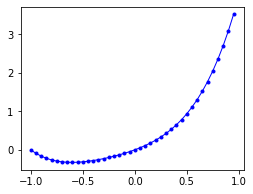

In [571]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (4,3))
ax = fig.add_subplot(111)
ax.plot(x, y, 'bo-', markersize = 3, linewidth = 1)
plt.show()

<b>0) Primitive definition </b>

In [375]:
# define primtives
arity_main = 1 # only x
pset = gp.PrimitiveSet('main', 1) # contain a set of primitives to be used
pset.addPrimitive(np.add, 2, name = "add") # operator, arity = the number of operands, name 
pset.addPrimitive(np.multiply, 2, name = "multiply")
pset.addPrimitive(np.subtract, 2, name = "substract")
pset.addPrimitive(np.negative, 1, name = "neg")
pset.renameArguments(ARG0 = "x")
#pset.addTerminal(1)

<b>1) Type defintion </b>

In [376]:
creator.create("SRFitnessMin", base.Fitness, weights = (-1.0,))
creator.create("SRIndividual", gp.PrimitiveTree, fitness = creator.SRFitnessMin, pset = pset)

/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'SRFitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'SRIndividual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


<b>2) Initialisation </b>

In [403]:
min_depth = 0
init_max_depth = 3 
pop_size = 50

sr_toolbox = base.Toolbox()
# gp.genFull, gp.genHalfAndHalf, gp.genGrow
sr_toolbox.register("expr", gp.genFull, pset = pset, min_ = min_depth, max_ = init_max_depth)
sr_toolbox.register("individual", tools.initIterate, creator.SRIndividual, sr_toolbox.expr)
sr_toolbox.register("population", tools.initRepeat, list, sr_toolbox.individual, n = pop_size)

<b>3) Operator defintion & register </b>

In [404]:
def eval_expr(expr, x, y, pset):
    from sklearn.metrics import mean_squared_error
    # Y = the ground truth 
    comp_y = gp.compile(expr, pset)(x)
    mse = mean_squared_error(y, comp_y, squared=False)
    return (mse,)  

sr_toolbox.register("evaluate", eval_expr, x = x, y = y, pset = pset)
sr_toolbox.register("mate", gp.cxOnePoint)
sr_toolbox.register("mutate", gp.mutUniform, expr = sr_toolbox.expr, pset = pset)
sr_toolbox.register("select", tools.selTournament, tournsize = 3)

In [ ]:
# limit
import operator 
max_tree_depth = 20
sr_toolbox.decorate("mate", 
    gp.staticLimit(
        key = operator.attrgetter("height"), 
        max_value = max_tree_depth
    )
)

sr_toolbox.decorate("mutaet", 
    gp.staticLimit(
        key = operator.attrgetter("height"), 
        max_value = max_tree_depth
    )
)

<b>4) Algorithm </b>

In [405]:
n_gen = 20
cxRate = 1.0
mutRate = 0.2

In [439]:
# 1) population initialisaiton 
pop = sr_toolbox.population(n = pop_size)

In [440]:
# 2) fitness evaluation 
fitness_per_ind = sr_toolbox.map(sr_toolbox.evaluate, pop) 
for ind,fit_v in zip(pop, fitness_per_ind):
    ind.fitness.values = fit_v 

In [441]:
# 2-2) select the best individual & store
best = tools.HallOfFame(1)
best.update(pop)
print (best[0], best[0].fitness.values)

x (0.8036953989351546,)


In [442]:
# logging 
stats = tools.Statistics(lambda ind:ind.fitness.values[0])
stats.register("max", np.max, axis = 0)
stats.register("min", np.min, axis = 0)
stats.register("mean",np.mean, axis = 0)
stat_results = stats.compile(pop)
logbook = tools.Logbook()
logbook.record(gen = 0, min = stat_results['min'], max = stat_results['max'], mean = stat_results['mean'])
print (logbook)

gen	max    	mean   	min     
0  	2.13417	1.15713	0.803695


In [556]:
# 3) evolution & 4) next population selection 
for gen_idx in range(1, n_gen + 1):
    # 3) evolution
    offsprings = []
    pop_copied = [sr_toolbox.clone(ind) for ind in pop]
    while len(offsprings) < pop_size:
        offspring = sr_toolbox.select(pop_copied, 2)
        ind1, ind2 = algorithms.varAnd(offspring, sr_toolbox, cxRate, mutRate)
        offsprings.extend([ind1, ind2])
    
    ind_fit_inv = [ind for ind in offsprings if not ind.fitness.valid]
    fitness_per_ind = sr_toolbox.map(sr_toolbox.evaluate, ind_fit_inv)
    for ind, fit_v in zip(ind_fit_inv, fitness_per_ind):
        ind.fitness.values = fit_v 
    
    # 4) next popluation selection 
    pop[:] = tools.selBest(pop + offsprings, pop_size)
    
    # update the best
    best.update(pop)

    # logging
    stat_results = stats.compile(pop)
    logbook.record(gen = gen_idx, 
        min = stat_results['min'], max = stat_results['max'], mean = stat_results['mean']
    )
    print (logbook)
    print (f"\tGen {gen_idx}:\n\t\tbest:{str(best[0])}\n\t\tfitness:{best[0].fitness.values[0]}")

gen	max     	mean    	min     
0  	2.86537 	1.13692 	0.434701
1  	0.944615	0.804013	0.434701
	Gen 1:
		best:add(add(multiply(x, x), add(x, x)), substract(neg(x), neg(x)))
		fitness:0.43470072020245343
gen	max     	mean    	min     
0  	2.86537 	1.13692 	0.434701
1  	0.944615	0.804013	0.434701
2  	0.803695	0.75482 	0.434701
	Gen 2:
		best:add(add(multiply(x, x), add(x, x)), substract(neg(x), neg(x)))
		fitness:0.43470072020245343
gen	max     	mean    	min     
0  	2.86537 	1.13692 	0.434701
1  	0.944615	0.804013	0.434701
2  	0.803695	0.75482 	0.434701
3  	0.803695	0.711346	0.434701
	Gen 3:
		best:add(add(multiply(x, x), add(x, x)), substract(neg(x), neg(x)))
		fitness:0.43470072020245343
gen	max     	mean    	min     
0  	2.86537 	1.13692 	0.434701
1  	0.944615	0.804013	0.434701
2  	0.803695	0.75482 	0.434701
3  	0.803695	0.711346	0.434701
4  	0.803695	0.590686	0.434701
	Gen 4:
		best:add(add(multiply(x, x), add(x, x)), substract(neg(x), neg(x)))
		fitness:0.43470072020245343
gen	max   

In [559]:
str(best[0])

'add(add(multiply(x, x), add(x, x)), substract(neg(x), multiply(neg(x), substract(add(substract(neg(x), multiply(neg(x), substract(add(multiply(x, x), add(x, x)), x))), add(x, x)), x))))'

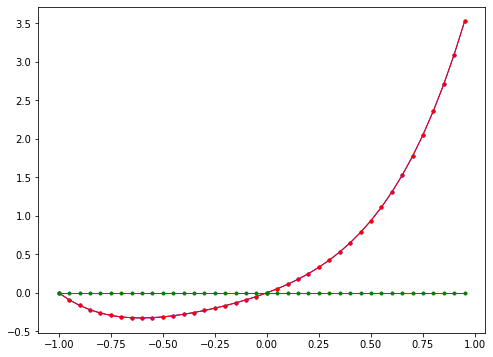

In [569]:
y_computed = gp.compile(best[0], pset=pset)(x)

import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.plot(x, y, 'bo-', markersize = 3, linewidth = 1)
ax.plot(x, y_computed, 'ro-', markersize = 3, linewidth = 1)
ax.plot(x, y - y_computed, 'go-', markersize = 3, linewidth = 1)
plt.show()

In [ ]:
#out = algorithms.eaSimple(pop, sr_toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)

In [562]:
%pip install pygraphviz

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [55 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-12-x86_64-cpython-39
      creating build/lib.macosx-12-x86_64-cpython-39/pygraphviz
      copying pygraphviz/scraper.py -> build/lib.macosx-12-x86_64-cpython-39/pygraphviz
      copying pygraphviz/graphviz.py -> build/lib.macosx-12-x86_64-cpython-39/pygraphviz
      copying pygraphviz/__init__.py -> build/lib.macosx-12-x86_64-cpython-39/pygr

In [563]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

nodes, edges, labels = gp.graph(best[0])
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

nx.draw_networkx_nodes(graph, pos, node_size=900, node_color="w")
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos, labels)
plt.show()
    

ImportError: requires pygraphviz http://pygraphviz.github.io/

#### Exercises

<b>Even Parity Generator</b>

* Individual: a candidate expression/generator 
* Fitness: 
    - Maximise the number of correctly computed even parity bits 
    - Or Minimise the number of wrongly computed even parity bits
* crossover: a single point crossover 
    - gp.cxOnepoint 
* mutation: 
    - gp.mutUniform
* next population selection: select the top pop_size best individuals 
    - tools.selBest 
* primitives:
    - operator.and_, operator.or_, operator.xor, operator.not_
* terminals:
    - 1 and 0 

In [ ]:
import operator 

In [627]:
pop_size = 100 
seq_size = 6
n_parity = 2**seq_size

In [628]:
# provided

# dataset
data_seqs = []
parity_bits =[]
for i in range(n_parity):
    data_seqs.append([])
    v = i 
    parity = 0 
    dividor = n_parity
    for j in range(seq_size):
        dividor /= 2
        if v >= dividor:
            data_seqs[-1].append(1)
            parity = int(not parity)
            v -= dividor 
        else:
            data_seqs[-1].append(0)
    parity_bits.append(parity)

In [646]:
import operator 

# define a primtive set
pset = gp.PrimitiveSet("main", seq_size)
#perator.and_, operator.or_, operator.xor, operator.not_
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.xor, 2)
pset.addPrimitive(operator.not_, 1)
pset.addTerminal(1)
pset.addTerminal(0)

# define types 
creator.create("EPFitnessMax", base.Fitness, weights = (1.0,))
creator.create("EPIndividual", gp.PrimitiveTree, fitness = creator.EPFitnessMax, pset = pset)

# initialisation 
min_depth = 3
init_max_depth = 5
ep_toolbox = base.Toolbox()
ep_toolbox.register("expr", gp.genFull, pset = pset, min_ = min_depth, max_ = init_max_depth)
ep_toolbox.register("individual", tools.initIterate, creator.EPIndividual, ep_toolbox.expr)
ep_toolbox.register("population", tools.initRepeat, list, ep_toolbox.individual, n = pop_size)

# operators
def eval_generator(expr, x, y, pset):
    comp_expr = gp.compile(expr, pset)
    num_corr = np.sum([comp_expr(*_x) == _y for _x,_y in zip(x,y)])
    return num_corr,

ep_toolbox.register("evaluate", eval_generator, x = data_seqs, y = parity_bits, pset = pset)
ep_toolbox.register("mate", gp.cxOnePoint)
ep_toolbox.register("mutate", gp.mutUniform, expr = sr_toolbox.expr, pset = pset)
ep_toolbox.register("select", tools.selTournament, tournsize = 3)

n_gen = 50
cxRate = 0.5
mutRate = 0.2

# 1) population initialisaiton 
pop = ep_toolbox.population(n = pop_size)
# 2) fitness evaluation 
fitness_per_ind = ep_toolbox.map(ep_toolbox.evaluate, pop) 
for ind,fit_v in zip(pop, fitness_per_ind):
    ind.fitness.values = fit_v 
# 2-2) select the best individual & store
best = tools.HallOfFame(1)
best.update(pop)

# logging 
stats = tools.Statistics(lambda ind:ind.fitness.values[0])
stats.register("max", np.max, axis = 0)
stats.register("min", np.min, axis = 0)
stats.register("mean",np.mean, axis = 0)
stat_results = stats.compile(pop)
logbook = tools.Logbook()
logbook.record(
    gen = 0, min = stat_results['min'], max = stat_results['max'], mean = stat_results['mean'])
print (logbook)

# 3) evolution & 4) next population selection 
for gen_idx in range(1, n_gen + 1):
    # 3) evolution
    offsprings = []
    pop_copied = [ep_toolbox.clone(ind) for ind in pop]
    while len(offsprings) < pop_size:
        offspring = ep_toolbox.select(pop_copied, 2)
        ind1, ind2 = algorithms.varAnd(offspring, ep_toolbox, cxRate, mutRate)
        offsprings.extend([ind1, ind2])
    
    # 4) next population selection & fitness computation for new offsrpings 
    ind_fit_inv = [ind for ind in offsprings if not ind.fitness.valid]
    fitness_per_ind = ep_toolbox.map(ep_toolbox.evaluate, ind_fit_inv)
    for ind, fit_v in zip(ind_fit_inv, fitness_per_ind):
        ind.fitness.values = fit_v 
    pop[:] = tools.selBest(pop + offsprings, pop_size)
    
    # 4-2) the next population selection 
    best.update(pop)

    # logging
    stat_results = stats.compile(pop)
    logbook.record(gen = gen_idx, 
        min = stat_results['min'], max = stat_results['max'], mean = stat_results['mean']
    )
    print (logbook)
    print (f"\tGen {gen_idx}:\n\t\tbest:{str(best[0])}\n\t\tfitness:{best[0].fitness.values[0]}")

gen	max	mean 	min
0  	36 	32.02	28 
gen	max	mean 	min
0  	36 	32.02	28 
1  	36 	32.45	32 
	Gen 1:
		best:and_(xor(or_(xor(and_(ARG0, ARG4), not_(ARG5)), and_(and_(ARG3, 0), xor(ARG0, ARG1))), or_(and_(or_(ARG4, ARG0), and_(ARG2, ARG0)), not_(xor(ARG2, ARG3)))), not_(or_(xor(and_(ARG0, ARG2), not_(ARG1)), not_(not_(ARG3)))))
		fitness:36.0
gen	max	mean 	min
0  	36 	32.02	28 
1  	36 	32.45	32 
2  	36 	33.31	32 
	Gen 2:
		best:and_(xor(or_(xor(and_(ARG0, ARG4), not_(ARG5)), and_(and_(ARG3, 0), xor(ARG0, ARG1))), or_(and_(or_(ARG4, ARG0), and_(ARG2, ARG0)), not_(xor(ARG2, ARG3)))), not_(or_(xor(and_(ARG0, ARG2), not_(ARG1)), not_(not_(ARG3)))))
		fitness:36.0
gen	max	mean 	min
0  	36 	32.02	28 
1  	36 	32.45	32 
2  	36 	33.31	32 
3  	38 	34.3 	33 
	Gen 3:
		best:and_(xor(or_(xor(and_(ARG0, ARG4), not_(ARG5)), and_(and_(ARG3, 0), xor(ARG0, ARG1))), or_(and_(or_(ARG4, ARG0), and_(ARG2, ARG0)), not_(xor(ARG2, ARG3)))), not_(or_(xor(and_(ARG0, ARG2), not_(ARG1)), not_(ARG4))))
		fitness:38.0
g

In [647]:
best[0].fitness

deap.creator.EPFitnessMax((64.0,))